In [2]:
# SPDX-FileCopyrightText: 2022 Aleksander Grochowicz
#
# SPDX-License-Identifier: GPL-3.0-or-later

from matplotlib.ticker import AutoMinorLocator
import pandas as pd
from datetime import date
import holidays
from utilities import compute_cdd_hdd_artificial, create_daily_data, create_hourly_data

# Load temperature data

In [3]:
# .txt files from ERA5 notebook
temperatures = pd.read_csv('original_data/temp_moy_FR19_20.txt', header = None)
temperatures.columns = ['FR']
year = 2019
index =  pd.date_range(start='2019-10-01', end='2020-03-31 23:00:00', freq='H')
temperatures.index =index

C:\Users\JD278300\AppData\Local\Temp\ipykernel_9364\250199297.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index =  pd.date_range(start='2019-10-01', end='2020-03-31 23:00:00', freq='H')


In [4]:
len(index)

4392

In [5]:
# temperatures = pd.read_csv('original_data/europe_temperatures_1980-2020.csv', index_col = [0], infer_datetime_format=True)
# temperatures.drop('IS', axis = 1) # Remove Iceland
# temperatures.index = pd.to_datetime(temperatures.index)

# Load regression parameters


In [7]:
reg_parameters_days = pd.read_csv('processing/justine_europe_parameters_days_of_week_2010-2014_17.csv', index_col = [0])
# reg_parameters_hours = pd.read_csv('processing/reg_parameters_hours_of_week_2010-2014.csv', index_col = [0])
reg_parameters_temp = pd.read_csv('processing/justine_europe_parameters_temp_2010-2014_17.csv', index_col = [0])
reg_parameters_trend = pd.read_csv('processing/justine_europe_parameters_trend_2010-2014_17.csv', index_col = [0])

In [7]:
reg_parameters_days = pd.read_csv('processing/justine_europe_parameters_days_of_week_2010-2014_16_24.csv', index_col = [0])
# # reg_parameters_hours = pd.read_csv('processing/reg_parameters_hours_of_week_2010-2014.csv', index_col = [0])
reg_parameters_temp = pd.read_csv('processing/justine_europe_parameters_temp_2010-2014_16_24.csv', index_col = [0])
reg_parameters_trend = pd.read_csv('processing/justine_europe_parameters_trend_2010-2014_16_24.csv', index_col = [0])# 

In [8]:
reg_parameters_temp

,AT,BE,BG,CH,CZ,DE,DK,EE,ES,FI,...,MK,NL,NO,PL,PT,RO,RS,SE,SI,SK
par_heating,72.730603,124.959202,101.730595,92.099312,98.978952,440.416382,57.58241,16.924577,398.788948,144.913958,...,25.603180,103.499369,384.489256,139.863294,99.713410,67.974536,114.557171,335.537513,9.781306,31.402586
par_cooling,84.669091,0.000000,50.125177,208.434614,18.451165,282.779941,0.00000,3.305383,486.543680,123.574743,...,10.021707,102.864003,0.000000,86.425285,55.783026,58.082863,11.482181,231.439534,9.234649,12.125827


In [9]:
# Dans un premier temps on s'intéresse aux coeffcients de régression pour la France
reg_days_FR = reg_parameters_days['FR']
# reg_hours_FR = reg_parameters_hours['FR']
reg_temp_FR = reg_parameters_temp['FR']
reg_trend_FR = reg_parameters_trend['FR']

reg_trend_FR=pd.DataFrame(reg_trend_FR)
reg_days_FR=pd.DataFrame(reg_days_FR)
# reg_hours_FR=pd.DataFrame(reg_hours_FR)
reg_temp_FR=pd.DataFrame(reg_temp_FR)

# reg_trend_FR.columns = ['KR']
# reg_days_FR.columns = ['KR']
# reg_hours_FR.columns = ['KR']
# reg_temp_FR.columns = ['KR']


Since our validation year is 2015, compared to the training data from 2010 to 2014, all weather years that we use will be processed on the premise that they happened in 2015.

In [10]:
years = list(temperatures.index.to_series().dt.year.unique())
countries = list(temperatures.columns)

Add holidays as previously with the `holidays` package and by adding Christmas week and for some countries Orthodox Christmas. 

In [11]:
list_holidays = {}
yrs = years.copy()
for c in countries:
    if c == 'EL':
        list_holidays[c] = holidays.CountryHoliday('GR', years = yrs)
    else:
        try:
            list_holidays[c] = holidays.CountryHoliday(c, years = yrs)
        except KeyError:
            list_holidays[c] = holidays.HolidayBase() #if no holidays are available, e.g. ME, MK        

# julian = ['ME', 'MK', 'RS']
# gregorian = countries.copy()
# for i in countries:
#     if i in julian:
#         gregorian.remove(i)

# # Add last week of the year as holidays.
# for y in list(yrs):
#     for i in gregorian:
#         list_holidays[i].append(date(y,1,2))
#         list_holidays[i].append(list(pd.date_range(start = date(y, 12, 24), end = date(y, 12, 31), freq = '1D')))
#     for i in julian:
#         list_holidays[i].append(list(pd.date_range(start = date(y, 1, 6), end = date(y, 1, 8), freq = '1D')))
        

In [12]:
# #Add German holidays before reunification (so include reunification as everything is assumed to be in 2015)
# overlapping_holidays = ['Neujahrestag', 'Karfreitag', 'Ostermontag', 'Auffahrt', 'Pfingstmontag', 'Weihnachten']
# for y in range(1980, 1991):
#     for date, name in sorted(holidays.CH(years = y).items()):
#         if name in overlapping_holidays:
#             list_holidays['DE'].append({date: name})
#     list_holidays['DE'].append(str(y)+'-05-01')
#     list_holidays['DE'].append(str(y)+'-10-03')
#     list_holidays['DE'].append(str(y)+'-12-26')

In [13]:
# #Add Slovenian holidays before 1992
# AT_SI = ['Neujahr', 'Allerheiligen', 'Stefanitag'] #New Year's, All Saints Day, Independence Day on Boxing Day
# for y in range(1980, 1992):
#     for date, name in sorted(holidays.AT(years = y).items()):
#         if name in AT_SI:
#             list_holidays['SI'].append({date: name})
#     list_holidays['SI'].append(str(y)+'-02-08') #Preseren Day
#     list_holidays['SI'].append(str(y)+'-04-27') #Day of uprising against occupation
#     list_holidays['SI'].append(str(y)+'-05-01') #May 1
#     list_holidays['SI'].append(str(y)+'-05-02') #May 1 over two days
#     list_holidays['SI'].append(str(y)+'-06-25') #Statehood Day

In [14]:
# #Add Bulgarian holidays before 1990
# RO_BG = ['Paștele', 'Anul Nou', 'Ziua Muncii', 'Crăciunul'] #Orthodox Easter, New Year, First of May, Christmas
# for y in range(1980, 1990):
#     for date, name in sorted(holidays.RO(years = y).items()):
#         if name in RO_BG:
#             list_holidays['BG'].append({date: name})
#     list_holidays['BG'].append(str(y)+'-03-03') #Liberation Day
#     list_holidays['BG'].append(str(y)+'-05-06') #Saint George's Day
#     list_holidays['BG'].append(str(y)+'-05-24') #Bulgarian Education and Culture and Slavonic Literature Day
#     list_holidays['BG'].append(str(y)+'-09-06') #Unification Day
#     list_holidays['BG'].append(str(y)+'-09-22') #independence Day

Compute HDD and CDD for all years (with the threshold at 15.5 degrees Celsius).

In [15]:
temperatures_daily = temperatures.resample('1D').mean()
temperatures_daily['weekday'] = temperatures_daily.index.to_series().dt.dayofweek
temperatures_daily['holiday'] = False
temp_daily = {}
for i in countries:
    temp_daily[i] = pd.DataFrame(temperatures_daily[[i, 'weekday', 'holiday']])
    temp_daily[i].columns = ['temp', 'weekday', 'holiday']
temp_with_holidays = temp_daily.copy()
for i in temp_with_holidays.keys():
    for j in temp_with_holidays[i].index:
        if j in list_holidays[i]:
            temp_with_holidays[i].at[j, 'holiday'] = True

In [17]:
daily_hc = compute_cdd_hdd_artificial(temp_daily, countries, threshold_hdd = 17, threshold_cdd = 17)

In [18]:
daily_hc['FR']['cooling'].unique()

array([0.        , 1.24883931, 0.15459722])

Create the artificial demand

In [19]:
countries = list(temperatures.columns)

In [20]:
#Adaptation pour année incomplète comme RTE
import calendar
import numpy as np
def create_daily_data(
    daily_profile,
    trend,
    input_data,
    temp_par,
    place,
    start,
    end,
    validation_days=0,
):
    """Create artificial data based on two regressions from before, one on the weekly load profile and one on the regression on daily values. Also outputs number of days for\
    validation purposes in subsequent period.
    
    Keyword arguments:
    daily_profile -- regression on daily temperature/demand values
    trend -- whether to include trend parameters
    input_data -- temperature data to be used as input
    temp_par -- temperature parameters from regression
    place -- list of keys of data 
    [start, end) -- time period to be studied 
    validation_days -- number of days to move trend for validation runs
    """
    # print(temp_par)
    artificial_daily = {}
    first_day = []
    first_day = int(input_data[place[0]].iloc[0]["weekday"])
    days = 0
    difference = end-start
    days  = difference.days +1
    # for year in range(start, end):
    #     if calendar.isleap(year) == True:
    #         days += 366
    #     else:
    #         days += 365
    for i in place:
        artificial_daily[i] = np.zeros(days)
        
        for j in range(days):
            k = (j + first_day) % 7
            if input_data[i]["holiday"].iloc[j] == 1:
                # print('here')
                artificial_daily[i][j] = (
                    trend.loc[i] * (validation_days + j)
                    # + daily_profile[i].iloc[6]
                    + input_data[i].iloc[j]["heating"] * temp_par.loc[i]["par_heating"]
                    + input_data[i].iloc[j]["cooling"] * temp_par.loc[i]["par_cooling"]
                )
            else:
            #     print('there')
                artificial_daily[i][j] = (
                    trend.loc[i] * (validation_days + j)
                    # + daily_profile[i].iloc[k]
                    + input_data[i].iloc[j]["heating"] * temp_par.loc[i]["par_heating"]
                    + input_data[i].iloc[j]["cooling"] * temp_par.loc[i]["par_cooling"]
                )
        # print('there2')
        artificial_daily[i] = pd.Series(artificial_daily[i], index=input_data[i].index)
        # print('end')
    return artificial_daily, days, first_day

In [21]:
from datetime import datetime
date1 = datetime(2019, 10, 1)
date2 = datetime(2020, 3, 31)

In [22]:
# artificial_demand_daily, days, first_day = create_daily_data(reg_parameters_days, reg_parameters_trend.loc["par_trend"], daily_hc, reg_parameters_temp.T, countries, start = 1980, end= 2021, validation_days=1826)
artificial_demand_daily, days, first_day = create_daily_data(reg_days_FR, reg_trend_FR.loc["par_trend"], daily_hc, reg_temp_FR.T, countries, start = date1, end= date2)

In [23]:
def plot_artificial(artificial, real, frequency, place):
    """Plot time series of artificial daily data (resampled if desired) compared to base data."""
    fig, ax = plt.subplots(nrows=len(place), ncols=1, figsize=(24, 6 * nb_c))
    for (i, x) in enumerate(place):
        artificial[x].resample(frequency).mean().plot(ax=ax[i], color="r", alpha=0.5)
        real[x]["demand"].resample(frequency).mean().plot(
            ax=ax[i], color="b", alpha=0.5
        )
        ax[i].set_title(
            f"Actual measured demand in {x} and projected demand based on regression with frequency {frequency}."
        )
        red_patch = mpl.patches.Patch(color="red", alpha=0.5, label="Projected demand")
        blue_patch = mpl.patches.Patch(
            color="blue", alpha=0.5, label="Real demand data"
        )
        ax[i].legend(handles=[red_patch, blue_patch])


In [24]:
artificial_demand_ts=artificial_demand_daily['FR']

In [25]:
artificial_demand_ts.to_csv('FR_demand_artificial_test_RTE_17.csv')

In [26]:
artificial_demand_ts = pd.read_csv('FR_demand_artificial_test_RTE_17.csv')
artificial_demand_ts = artificial_demand_ts.set_index('Unnamed: 0')
artificial_demand_ts.index = pd.DatetimeIndex(artificial_demand_ts.index)

In [27]:
artificial_demand_ts_1 = pd.read_csv('FR_demand_artificial_test_RTE_18_24.csv')
artificial_demand_ts_1 = artificial_demand_ts_1.set_index('Unnamed: 0')
artificial_demand_ts_1.index = pd.DatetimeIndex(artificial_demand_ts.index)

In [28]:
artificial_demand_ts_3 = pd.read_csv('FR_demand_artificial_test_RTE_16_24.csv')
artificial_demand_ts_3 = artificial_demand_ts_3.set_index('Unnamed: 0')
artificial_demand_ts_3.index = pd.DatetimeIndex(artificial_demand_ts_3.index)

In [29]:
artificial_demand_ts_2 = pd.read_csv('FR_demand_artificial_test_RTE_15.5.csv')
artificial_demand_ts_2 = artificial_demand_ts_2.set_index('Unnamed: 0')
artificial_demand_ts_2.index = pd.DatetimeIndex(artificial_demand_ts_2.index)

In [30]:
thermo_RTE = pd.read_csv('original_data/part_thermo_RTE_19_20.txt', header = None)
index = pd.date_range(start='2019-10-01', end='2020-03-30 23:00', freq='H')
thermo_RTE.index = index

C:\Users\JD278300\AppData\Local\Temp\ipykernel_9364\1484927744.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start='2019-10-01', end='2020-03-30 23:00', freq='H')


In [31]:
serie_journaliere = thermo_RTE.resample('D', closed='right').mean()
serie_journaliere

,0
2019-09-30,0.156900
2019-10-01,0.143304
2019-10-02,0.472604
2019-10-03,1.742825
2019-10-04,1.633112
...,...
2020-03-26,14.649613
2020-03-27,13.762608
2020-03-28,11.094483
2020-03-29,13.628504


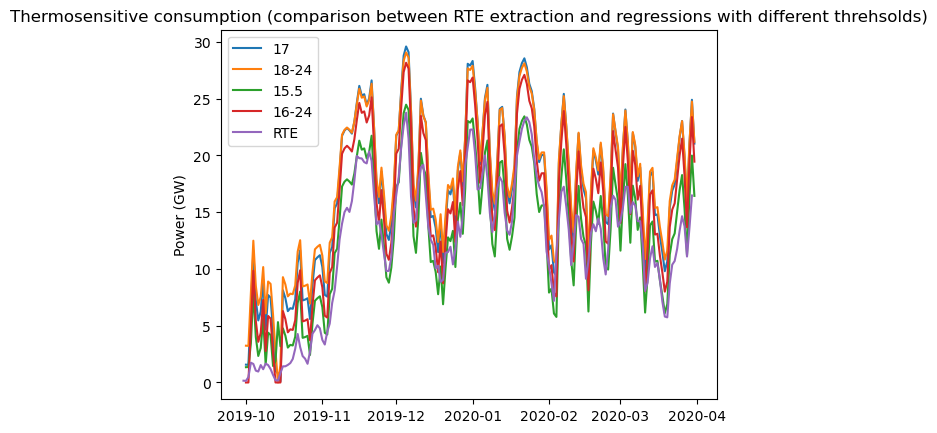

In [37]:
import matplotlib.pyplot as plt
plt.plot(artificial_demand_ts['0']/1000, label = '17')
plt.plot(artificial_demand_ts_1['0']/1000, label = '18-24')
plt.plot(artificial_demand_ts_2['0']/1000, label = '15.5')
plt.plot(artificial_demand_ts_3['0']/1000, label = '16-24')
plt.plot(serie_journaliere, label = 'RTE')

plt.title('Thermosensitive consumption (comparison between RTE extraction and regressions with different threhsolds)')
plt.ylabel('Power (GW)')
plt.legend()
plt.show()